# Average spectra

This example shows how to get the average power spectra with different choices of weights. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

from pyuvdata import UVData
import hera_pspec as hp
from hera_pspec.data import DATA_PATH

## Prepare power spectra

In [ ]:
dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')

# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 8.742104546399787e-05, largest imaginary/real ratio was 8.133899803697275e-12.


In [4]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# find conversion factor from Jy to mK
# Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, :, None]

In [10]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [11]:
ds.rephase_to_dset(0)
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [12]:
baselines = [(24,25), (37,38), (38,39)]
# calculate all baseline pairs from group
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True, 
                                                                 exclude_permutations=True)

In [13]:
uvp = ds.pspec(baselines1, baselines2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400)], input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=False)

Casting complex values to real discards the imaginary part


## Add analytic noise as error fields

In [14]:
keys = uvp.get_all_keys()

In [15]:
Pn = uvp.generate_noise_spectra(0, 'xx', 220)

In [16]:
for key in keys:
    print(key[1])
    blp = uvp.antnums_to_blpair(key[1])
    error = Pn[blp]
    print(error.shape)
    uvp.set_stats("noise", key, error)

((24, 25), (37, 38))
(3, 100)
((24, 25), (38, 39))
(3, 100)
((37, 38), (38, 39))
(3, 100)


## Take integration time as weights 

In [17]:
blpair_groups = [[((24, 25), (37, 38)),((24, 25), (38, 39)), ((37, 38), (38, 39))]]

In [18]:
uvp_avg_ints_wgts = hp.grouping.average_spectra(uvp, blpair_groups=blpair_groups,
                                                error_field="noise", time_avg=True,inplace=False)

## Take error bars as weights 

In [19]:
uvp_avg_error_wgts = hp.grouping.average_spectra(uvp, time_avg=True, blpair_groups=blpair_groups,
                                                 error_weights="noise", inplace=False)

If error_weights is specified, it will also be added to error_field. 

## Comparison on  power spectra 

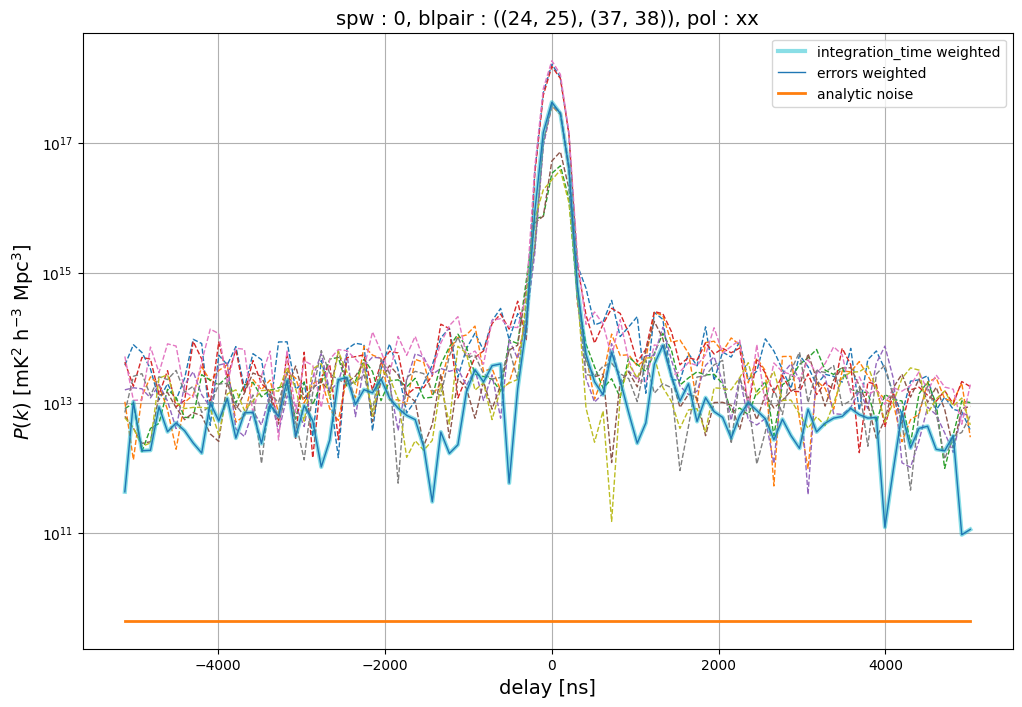

In [20]:
fig, ax = plt.subplots(figsize=(12,8))

key = (0, ((24, 25), (37, 38)), 'xx')
dlys = uvp.get_dlys(0) * 1e9
ps = np.abs(uvp.data_array[0][:,:,0])
ps_avg_ints = np.abs(np.real(uvp_avg_ints_wgts.get_data(key)))
ps_avg_errors = np.abs(np.real(uvp_avg_error_wgts.get_data(key)))
blp = uvp.antnums_to_blpair(((24, 25), (37, 38)))
ax.plot(dlys, ps.T, lw=1, ls="--")
ax.plot(dlys, ps_avg_ints.T, lw=3, label='integration_time weighted', alpha=0.5)
ax.plot(dlys, ps_avg_errors.T, lw=1, label="errors weighted")
ax.plot(dlys, Pn[blp][0,:], lw=2, label='analytic noise')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)
ax.legend(loc='best')

## Comparison on error field

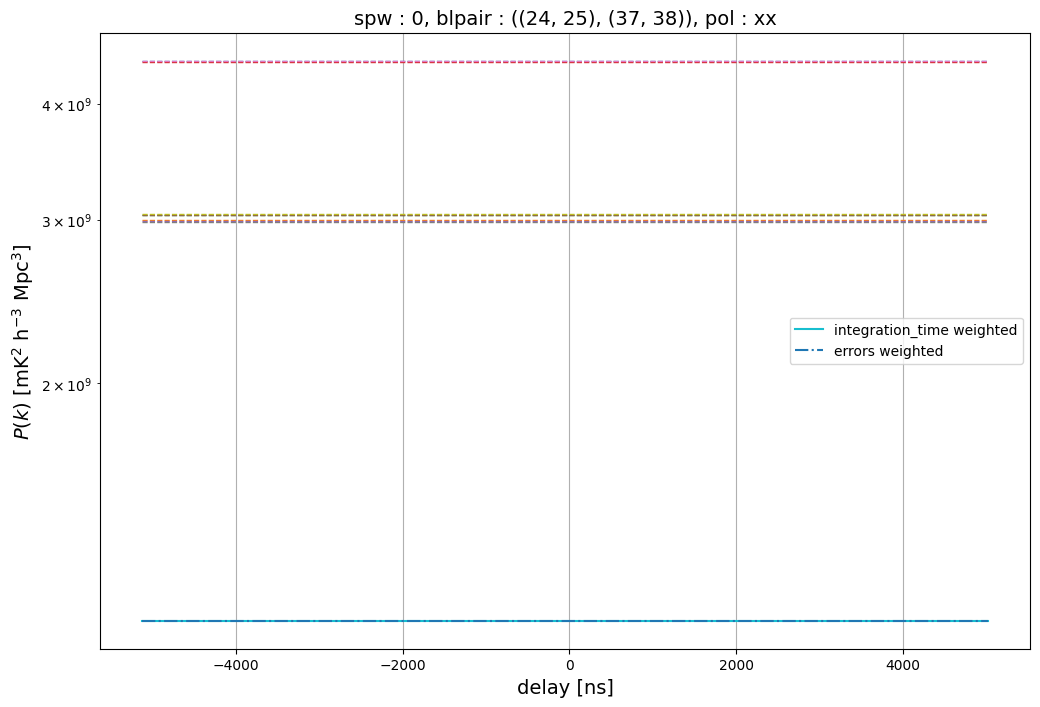

In [21]:
fig, ax = plt.subplots(figsize=(12,8))

key = (0, ((24, 25), (37, 38)), 'xx')
dlys = uvp.get_dlys(0) * 1e9
error = np.real(uvp.stats_array["noise"][0][:,:,0])
error_avg_ints = np.real(uvp_avg_ints_wgts.get_stats("noise", key))
error_avg_errors = np.real(uvp_avg_error_wgts.get_stats("noise", key))

ax.plot(dlys, error.T, lw=1, ls="--")
ax.plot(dlys, error_avg_ints.T, label='integration_time weighted')
ax.plot(dlys, error_avg_errors.T,ls="-.", label="errors weighted")
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)
ax.set_yscale('log')
ax.legend(loc='best')

## Comparison on integration time

In [22]:
uvp.get_integrations(key)

array([393.33100409, 584.25370598, 576.92974103])

In [23]:
uvp_avg_ints_wgts.get_integrations(key)

array([546.14991738])

In [24]:
uvp_avg_error_wgts.get_integrations(key)

array([546.14991738])

## Comparison on weights

In [25]:
uvp.get_wgts(key)[0,:,:]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.

In [26]:
uvp_avg_ints_wgts.get_wgts(key)[0,:,:]

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.

In [27]:
uvp_avg_error_wgts.get_wgts(key)[0,:,:]

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.